# PCA, Clustering, and Profiles
High-level dimensionality reduction plus quick segment clustering for hotel bookings.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [19]:
data_path = Path("../processed data/hotel_bookings_final.pkl")
df = pd.read_pickle(data_path)

# Ensure all features are numeric for PCA
# (some categorical columns may still be present in the saved pickle)
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop(columns=["is_canceled"])
y = df["is_canceled"]

# Scale features for PCA stability
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)



In [20]:
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_var)
print("Cumulative variance (2 components):", explained_var.sum())


Explained variance ratios: [0.01982714 0.01549505]
Cumulative variance (2 components): 0.035322182854782384


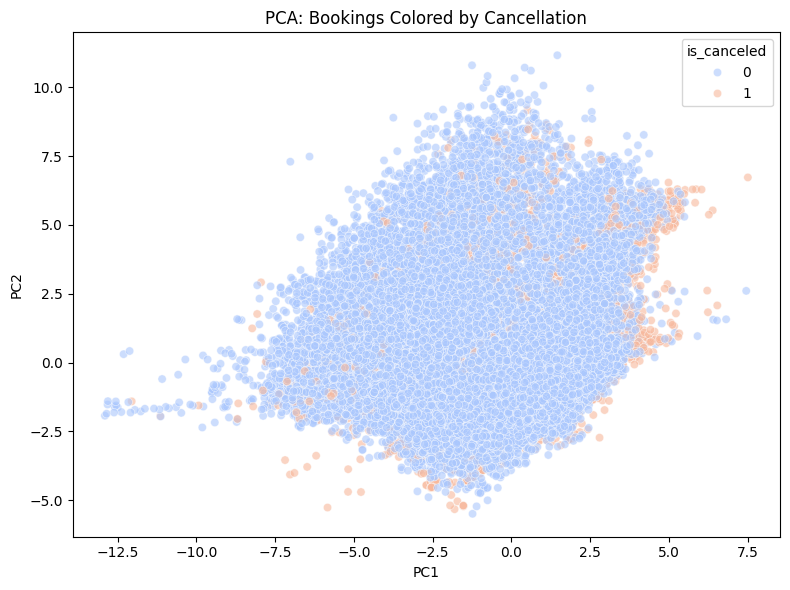

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y, palette="coolwarm", alpha=0.6)
plt.title("PCA: Bookings Colored by Cancellation")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="is_canceled")
plt.tight_layout()
plt.show()



In [22]:
# PCA loadings to see which features drive each component
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=["PC1","PC2"])

# Top absolute loadings per component
for pc in loadings.index:
    top_features = loadings.loc[pc].abs().sort_values(ascending=False).head(10)
    print(f"\nTop contributors for {pc}:")
    print(top_features)




Top contributors for PC1:
distribution_channel_TA/TO     0.347218
has_agent_flag                 0.334824
market_segment_Online TA       0.305092
distribution_channel_Direct    0.243791
total_guests                   0.229797
adults                         0.227177
market_segment_Corporate       0.226763
market_segment_Direct          0.214039
country_PRT                    0.208607
adr                            0.203772
Name: PC1, dtype: float64

Top contributors for PC2:
market_segment_Direct          0.286568
total_guests                   0.284596
distribution_channel_Direct    0.277915
children                       0.269473
adr                            0.254865
distribution_channel_TA/TO     0.219381
reserved_room_type_G           0.204931
assigned_room_type_G           0.203521
hotel_Resort Hotel             0.197410
has_parking                    0.197147
Name: PC2, dtype: float64


In [23]:
# Save PCA components for downstream visualization
output_dir = Path("../processed data")
output_dir.mkdir(parents=True, exist_ok=True)

pca_df = pd.DataFrame(pca_components, columns=["PC1","PC2"])
pca_df["is_canceled"] = y.reset_index(drop=True)

pca_df.to_pickle(output_dir / "hotel_pca_components.pkl")
loadings.to_pickle(output_dir / "hotel_pca_loadings.pkl")

pca_df.head()



,PC1,PC2,is_canceled
0,-4.198623,2.189635,0
1,-4.292861,2.290003,0
2,-4.475123,1.611602,0
3,-2.939947,-0.752659,0
4,0.649040,-0.394711,0


In [24]:
from sklearn.cluster import KMeans

# Simple 3-cluster pass on the 2D PCA space to segment bookings
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_components)

pca_df["cluster"] = clusters
pca_df.head()


,PC1,PC2,is_canceled,cluster
0,-4.198623,2.189635,0,2
1,-4.292861,2.290003,0,2
2,-4.475123,1.611602,0,2
3,-2.939947,-0.752659,0,2
4,0.649040,-0.394711,0,1


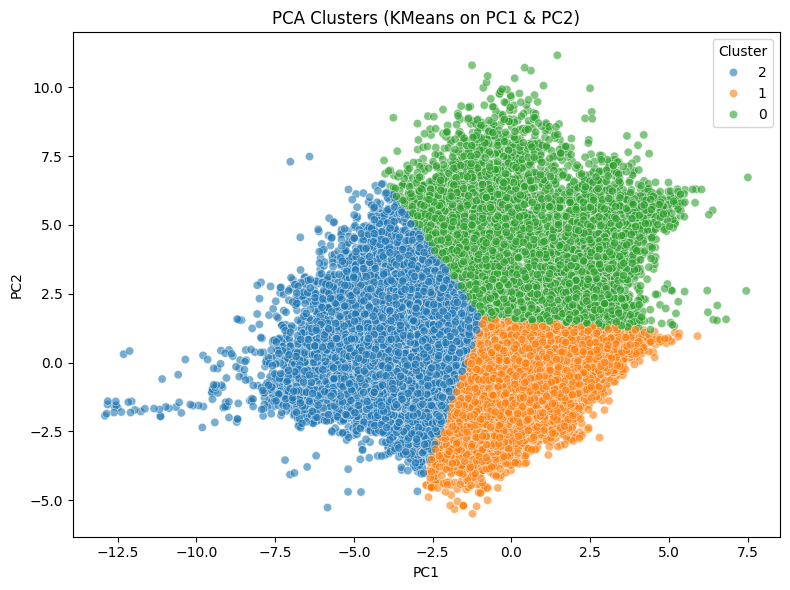

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=pca_df["cluster"].astype(str),
    palette="tab10",
    alpha=0.6
)
plt.title("PCA Clusters (KMeans on PC1 & PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [26]:
# Summarize top positive/negative loadings for each component
n_top = 6
for pc in ["PC1", "PC2"]:
    comp = loadings.loc[pc]
    top_pos = comp.sort_values(ascending=False).head(n_top)
    top_neg = comp.sort_values().head(n_top)
    print(f"\n{pc} — top +loadings:")
    print(top_pos)
    print(f"\n{pc} — top -loadings:")
    print(top_neg)




PC1 — top +loadings:
distribution_channel_TA/TO    0.347218
has_agent_flag                0.334824
market_segment_Online TA      0.305092
total_guests                  0.229797
adults                        0.227177
adr                           0.203772
Name: PC1, dtype: float64

PC1 — top -loadings:
distribution_channel_Direct      -0.243791
market_segment_Corporate         -0.226763
market_segment_Direct            -0.214039
country_PRT                      -0.208607
is_repeated_guest                -0.198638
previous_bookings_not_canceled   -0.145174
Name: PC1, dtype: float64

PC2 — top +loadings:
market_segment_Direct          0.286568
total_guests                   0.284596
distribution_channel_Direct    0.277915
children                       0.269473
adr                            0.254865
reserved_room_type_G           0.204931
Name: PC2, dtype: float64

PC2 — top -loadings:
distribution_channel_TA/TO      -0.219381
customer_type_Transient-Party   -0.132214
meal_SC           

In [27]:
# Quick cluster profile on a few interpretable (scaled) features
key_cols = [
    "lead_time",
    "adr",
    "total_of_special_requests",
    "previous_cancellations",
    "booking_changes",
    "deposit_type_Non Refund",
    "deposit_type_Refundable",
    "market_segment_Online TA",
    "market_segment_Groups",
    "distribution_channel_Online TA",
]

present_cols = [c for c in key_cols if c in df.columns]
cluster_profile = (
    pd.concat([df.reset_index(drop=True), pca_df[["cluster"]]], axis=1)
      .groupby("cluster")[present_cols]
      .mean()
)

print("Cluster profile (scaled feature means):")
cluster_profile


Cluster profile (scaled feature means):


,lead_time,adr,total_of_special_requests,previous_cancellations,booking_changes,deposit_type_Non Refund,deposit_type_Refundable,market_segment_Online TA,market_segment_Groups
cluster,,,,,,,,,
0,0.056004,1.312772,0.234480,-0.079815,0.231645,0.000378,0.000472,0.636226,0.001889
1,0.130006,-0.082382,0.057957,-0.050091,-0.100749,0.014166,0.000347,0.734210,0.049918
2,-0.518880,-0.547015,-0.367414,0.237755,0.223441,0.010858,0.004969,0.028158,0.116680


In [28]:
# Save enriched PCA outputs
output_dir = Path("../processed data")
output_dir.mkdir(parents=True, exist_ok=True)

pca_df.to_pickle(output_dir / "hotel_pca_components_with_clusters.pkl")
cluster_profile.to_pickle(output_dir / "hotel_pca_cluster_profile.pkl")

print("Saved:")
print("- hotel_pca_components_with_clusters.pkl")
print("- hotel_pca_cluster_profile.pkl")


Saved:
- hotel_pca_components_with_clusters.pkl
- hotel_pca_cluster_profile.pkl
